## Start project - extended!

The first part of my start project was on eddy kinetic energy (EKE) in the Antarctic circumpolar current (ACC). Anomalies in southern annular mode (SAM) and El Nino southern oscillation (ENSO) led to anomalies in EKE with 2-3 yrs time lag as described in [Morrow et al., 2010](https://doi.org/10.1029/2009JC005894).

The start project's intention was to gain basic understanding of the underlying data and derived indices. Now we want to dive deeper and try to calculate empirical orthogonal functions (EOFs). Before we do that, we have a look at certain assotiated "patterns":

For SAM, we should look at the projection of SLP onto the SAM index, reading roughly like 

*slp_pattern_sam = (sam * slp).mean("time")*

where SAM only has a "time" dimension, and slp has a "time" and other spatial dimensions. Xarray will take care of the broadcasting and the resulting *slp_pattern_sam* should only have the spatial dimensions left.

For ENSO, it would be interesting to first check the SST pattern (analogous to *slp_pattern_sam* above) and verify that indeed it shows the strongest anomalies in the NINO3.4 box used to define the index.

Then, the SLP pattern associated with ENSO is of interest as the argument of [Morrow et al., 2010](https://doi.org/10.1029/2009JC005894) is that the SLP pattern of positive SAM and positive ENSO anomalies largely cancel each other in the Pacific sector of the Southern Ocean.

Here we re-use parts of the calculations from notebook *03_MarDATA_Startprojekt*, without further explanation of how do derive SAM and ENSO indices.

In [31]:
# parameters
data_path = "/project_materials/pherproj-04/"

## Tech preamble

In [32]:
import dask

import xarray as xr

import hvplot.xarray
import geoviews as gv
import cartopy
import cmocean

from pathlib import Path
import os

from IPython.display import HTML, display
from matplotlib import pyplot as plt, animation
import matplotlib.patches as patches
import pandas as pd
import numpy as np

In [33]:
# # suppress deprecation warnings from cartopy / shapely
# from shapely.errors import ShapelyDeprecationWarning
# import warnings
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

## Prepare loading data

In [34]:
slp_path = Path(data_path) / "data/raw/ncep.reanalysis.derived/pres.sfc.mon.mean.nc"
sst_path = Path(data_path) / "data/raw/noaa.ersst.v5/sst.mnmean.nc"
ssh_path = Path(data_path) / "data/raw/SLTAC_GLO_PHY_L4_REP_v2.x.x_10daily.zarr"

## Caclutation SAM index from slp data

In [35]:
slp_dataset = xr.open_dataset(slp_path)
#slp_dataset

Paper [Gong & Wang (1999)](https://doi.org/10.1029/1999GL900003) defines Antarctic Oscillation Index (AOI) as the diffierence of zonal mean sea level pressure between 40°S and 65°S.

Paper [Morrow et al., 2010](https://doi.org/10.1029/2009JC005894) shows SAM index (with ENSO) over time from 1993 - 2008 in figure 2b, which we want to reproduce here.

Website https://www.cpc.ncep.noaa.gov/data/indices/Readme.index.shtml#SOICALC reveals, how Southern Oscillation Index (SOI) between Tahiti and Darwin is calculated. Calculation can be adapted, the southern annular mode index (SAM) is calculated from the difference of zonal-mean sea-level pressure (SLP) between 40°S and 65°S as follows:

In [36]:
# get zonal mean slp data for latitudes 40°S and 65°S, respectively
# note: We are only interested in slice from 1993 - 2008, but since we work with 12 months moving average
# later on, need longer input span here.
slp_lat40 = slp_dataset.pres.sel(lat=-40).sel(time=slice('1992-07-01','2009-05-01')).mean("lon")
slp_lat65 = slp_dataset.pres.sel(lat=-65).sel(time=slice('1992-07-01','2009-05-01')).mean("lon")

In [37]:
# Here we look at two different approaches for calculating SAM index:
# "Naive" version standardizes zonal mean slp BEFORE calculating the difference:

# standardize zonal mean slp data
slp_mean_lat40 = slp_lat40.mean("time")
slp_std_lat40 = slp_lat40.std("time")
slp_standardized_lat40 = (slp_lat40 - slp_mean_lat40) / slp_std_lat40
slp_mean_lat65 = slp_lat65.mean("time")
slp_std_lat65 = slp_lat65.std("time")
slp_standardized_lat65 = (slp_lat65 - slp_mean_lat65) / slp_std_lat65

In [38]:
# get monthly standard deviation (note: slp data comes in monthly intervals, thus don't need to resample) over time span of interest (1993-2008)
slp_standardized_diff = slp_standardized_lat40 - slp_standardized_lat65
MSD = slp_standardized_diff.sel(time=slice('1993-01-01','2008-12-31')).std("time")

In [39]:
# calculate SAM index
SAM_index = slp_standardized_diff / MSD

# calculate moving average (12 months)
SAM_index_avg = SAM_index.rolling(time=12, center=True).mean().dropna("time")

In [40]:
# Willis annotation: There's lots of confusion in the community about the correct way to standardise these indices. He would always go for 
# standardising (in time) the physical driver of the process we have in mind. Here, the driving force is the pressure gradient rather than the 
# difference of the standardised pressure values. So his personal preference would be to standardise the difference of zonally average SLP.

# So - for comparision - follow Willi's approach and calculate alternative version of SAM index:
slp_diff = slp_lat40 - slp_lat65
slp_diff_mean = slp_diff.mean("time")
slp_diff_std = slp_diff.std("time")
slp_diff_standardized = (slp_diff - slp_diff_mean) / slp_diff_std
SAM_index_alt = slp_diff_standardized / MSD
SAM_index_alt_avg = SAM_index_alt.rolling(time=12, center=True).mean().dropna("time")

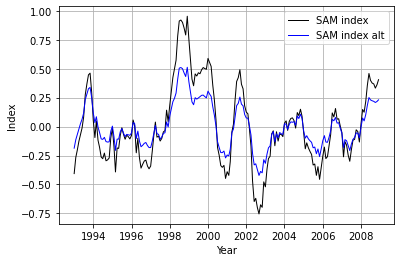

In [41]:
# Now plot two versions of SAM index for comparision.
# Note: SAM_index
plt.plot(SAM_index_avg.sel(time=slice('1993-01-01','2008-12-31')).time, SAM_index_avg.sel(time=slice('1993-01-01','2008-12-31')), label='SAM index', color='black', linewidth=1)
plt.plot(SAM_index_alt_avg.sel(time=slice('1993-01-01','2008-12-31')).time, SAM_index_alt_avg.sel(time=slice('1993-01-01','2008-12-31')), label='SAM index alt', color='blue', linewidth=1)
plt.ylabel('Index')
plt.xlabel('Year')
#plt.ylim([-2, 3])
plt.grid()
plt.legend()
plt.show()

# Observe that "naive" SAM index comes closer to SAM index shown in [Morrow et al., 2010]. So stick to this naive approach for now.

In [42]:
# now we have a look at the projection of slp onto the SAM index, reading roughly like 
# slp_pattern_sam = (sam * slp).mean("time"), where SAM only has a "time" dimension, 
# and slp has a "time" and other spatial dimensions. 
# Xarray takes care of the broadcasting and the resulting sst_pattern_enso only has the spatial dimensions left.

slp_all = slp_dataset.pres.sel(time=slice('1993-01-01','2008-12-31'))

slp_pattern_sam = (SAM_index_avg * slp_all).mean("time")

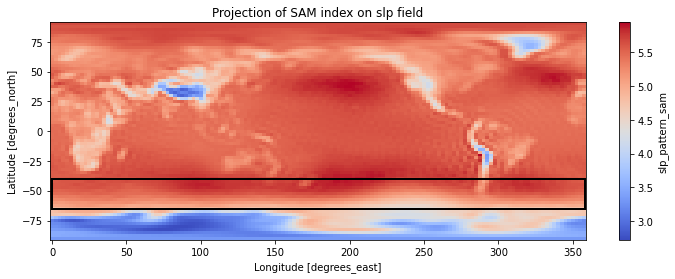

In [43]:
# plot slp pattern for the world, highlighting ACC region
fig, ax = plt.subplots(figsize=(12, 4))
slp_pattern_sam.name = 'slp_pattern_sam'
slp_pattern_sam.plot(ax=ax, cmap='coolwarm')
plt.title('Projection of SAM index on slp field')

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((0, -65), 358, 25, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

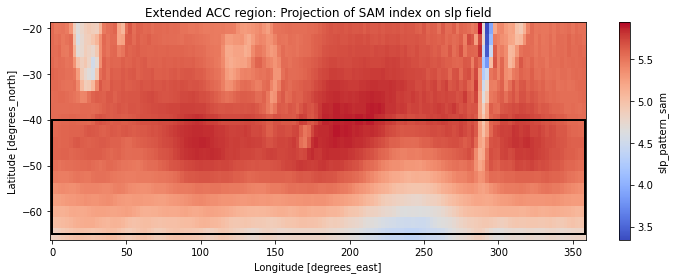

In [44]:
# plot slp pattern only for (a slightly extended!) ACC region
fig, ax = plt.subplots(figsize=(12, 4))
slp_pattern_sam.sel(lat=slice(-20,-65)).name = 'ACC: slp pattern (proj. on SAM)'
slp_pattern_sam.sel(lat=slice(-20,-65)).plot(ax=ax, cmap='coolwarm')
plt.title('Extended ACC region: Projection of SAM index on slp field')

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((0, -65), 358, 25, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

In [45]:
# plot slp pattern with view on Antarctis (as done in [Morrow et. al, 2010] figure 1a)
proj = cartopy.crs.NearsidePerspective(central_latitude=-90, central_longitude=20)

(
    slp_pattern_sam.rename("slp_pattern_sam").hvplot(
        geo=True,
        cmap='coolwarm',
        clim=(3.5,6),
        title="slp_pattern_sam",
        projection=proj,
    )
) * gv.feature.coastline(projection=proj)

:Overlay
   .Image.I     :Image   [lon,lat]   (slp_pattern_sam)
   .Coastline.I :Feature   [Longitude,Latitude]

#### Discussion on projection of SAM index onto slp field

By projecting SAM index onto the slp field we obtain *slp_pattern_sam*. This pattern shows **high values** for places where **high slp** coincide with **positive SAM anomalies**, at least on average over the time span of interest (here: 1993 - 2008).

So what we find is, that indeed positive SAM anomaly coincides with a longitudinal ring of high *slp* at the northern boundary of ACC region and low *slp* arround Antarctis area, hence at the lower edge of ACC region. Strongest anomaly ("dipole") can be observed in the southern Pacific.

## Calculating ENSO index from sst data

In [46]:
sst_dataset = xr.open_dataset(sst_path)
#sst_dataset

There are several indices used to monitor the tropical Pacific, all of which are based on SST anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The Niño 3.4 index is one of the most commonly used indices to define El Niño and La Niña events.

Website https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni gives introduction to ENSO indices. Paper [Morrow et al., 2010] shows index for Niño 3.4 region (5°N–5°S, 120–170°W) in the tropical Pacific. The website references a link to an "expert guide" with more detailed information and a recipe on calculating ENSO indices:

(...) Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period. (...)

In [47]:
# Compute area averaged total SST from Niño 3.4 region (5°N–5°S, 120–170°W).
# Note: Since the box of interest is close to equator (5°N-5°S) we simply average over the box area and don't take care
# of area weighting here.
# Note: latitude comes in a grid 88, 86, .., -86, 88, slice(5,-5) is actually using (4°N-4°S) only.
# Note: longitude ranges from 0 to 358°E. Region of interest (120-170°W) translates to (190°E-240°E) here.
# Note: We are only interested in slice from 1993 - 2008, but since we work with 5 months moving average
# later on, need longer input span here.
sst_mean = sst_dataset.sst.sel(time=slice('1992-11-01','2009-02-01')).sel(lat=slice(5,-5)).sel(lon=slice(190,240)).mean(("lat", "lon"))

In [48]:
# Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño 3.4 region
sst_base_mean = (
    sst_dataset.sst
    .sel(time=slice('1950-01-01','1979-12-01'))
    .sel(lat=slice(5,-5))
    .sel(lon=slice(190,240))
    .mean(("lat", "lon", "time"))
)

In [49]:
# Subtract climatology from area averaged total SST time series to obtain anomalies
sst_anomaly = sst_mean - sst_base_mean

In [50]:
# Smooth the anomalies with a 5-month running mean to get ENSO index
ENSO_index_avg = sst_anomaly.rolling(time=5, center=True).mean().dropna("time")

In [51]:
# Recipy for calculating ENSO index requires normalization of the smoothed values
# by its standard deviation over the climatological period.
# But [Morrow et al., 2010] seem to show unnormalized ENSO index. Hence skip normalization here.
sst_std = sst_dataset.sst.sel(time=slice('1950-01-01','1979-12-01')).sel(lat=slice(5,-5)).sel(lon=slice(190,240)).std(("lat", "lon", "time"))
ENSO_index_normalized = ENSO_index_avg / sst_std

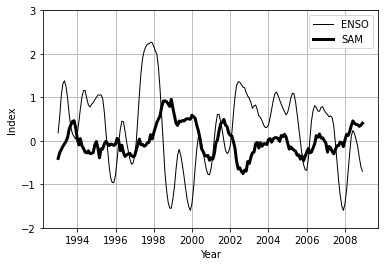

In [52]:
# Now combine SAM and ENSO indices in one plot to reproduce figure 2b of [Morrow et al., 2010]
plt.plot(ENSO_index_avg.time, ENSO_index_avg, label='ENSO', color='black', linewidth=1)
plt.plot(SAM_index_avg.time, SAM_index_avg, label='SAM', color='black', linewidth=3)
#plt.plot(ENSO_index_normalized.time, ENSO_index_normalized, label='ENSO norm', color='blue', linewidth=1)
plt.ylabel('Index')
plt.xlabel('Year')
plt.ylim([-2, 3])
plt.grid()
plt.legend()
plt.show()

In [53]:
# For ENSO, it would be interesting to first check the SST pattern (analogous to *slp_pattern_sam* above) 
# and verify that indeed it shows the strongest anomalies in the NINO3.4 box used to define the index.
sst_all = sst_dataset.sst.sel(time=slice('1993-01-01','2008-12-31'))
sst_pattern_enso = (ENSO_index_avg * sst_all).mean("time")

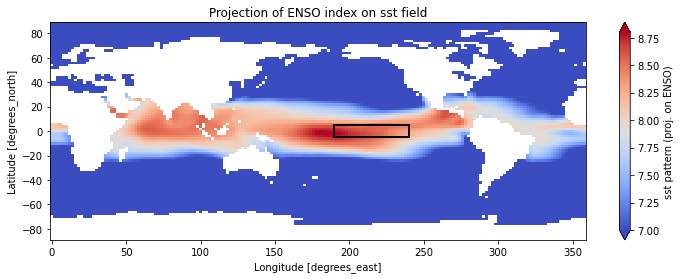

In [75]:
# plot sst/enso pattern for the world, with bounding box arround Nino3.4 area
fig, ax = plt.subplots(figsize=(12, 4))
sst_pattern_enso.name = 'sst pattern (proj. on ENSO)'
sst_pattern_enso.plot(ax=ax, cmap='coolwarm', vmax=8.8, vmin=7)
plt.title('Projection of ENSO index on sst field')

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((190, -5), 50, 10, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

#### Discussion on projection of ENSO index onto sst field

By projecting ENSO index onto the sst field we obtain *sst_pattern_enso*. This pattern shows places where **high sst** coincide with **positive ENSO anomalies**, at least on average over the time span of interest (here: 1993 - 2008). As expected, highest values of the pattern are observed in Pacific ocean, and partly fall into the Nino 3.4 box, from which ENSO index was defined.

In [55]:
# Then, the SLP pattern associated with ENSO is of interest as the argument of [Morrow et al., 2010]
# is that the SLP pattern of positive SAM and positive ENSO anomalies largely cancel each other 
# in the Pacific sector of the Southern Ocean.
slp_pattern_enso = (ENSO_index_avg * slp_all).mean("time")

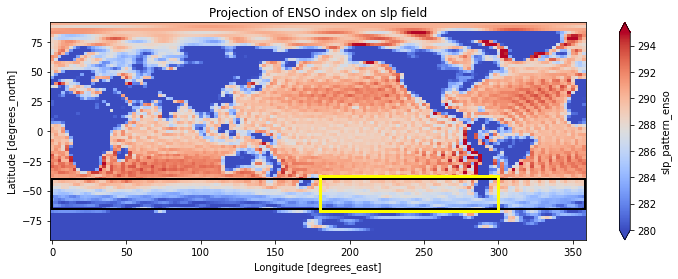

In [56]:
# plot slp/enso pattern for the world, highlighting ACC region
fig, ax = plt.subplots(figsize=(12, 4))
slp_pattern_enso.name = 'slp_pattern_enso'
slp_pattern_enso.plot(ax=ax, cmap='coolwarm', vmax=295, vmin=280)
plt.title('Projection of ENSO index on slp field')

# Create a Rectangle patch and add the patch to the Axes, for ACC region AND Pacific sector of ACC region
rect_ACC_Total = patches.Rectangle((0, -65), 358, 25, linewidth=2, edgecolor='black', facecolor='none')
rect_ACC_Pacific = patches.Rectangle((180, -67), 120, 29, linewidth=3, edgecolor='yellow', facecolor='none')
ax.add_patch(rect_ACC_Total)
ax.add_patch(rect_ACC_Pacific)

plt.show()

In [57]:
# plot slp pattern with view on Antarctis (as done in [Morrow et. al, 2010] figure 1b)
proj = cartopy.crs.NearsidePerspective(central_latitude=-90, central_longitude=20)

(
    slp_pattern_enso.rename("slp_pattern_enso").hvplot(
        geo=True,
        cmap='coolwarm',
        clim=(260,290),
        title="slp_pattern_enso",
        projection=proj,
    )
) * gv.feature.coastline(projection=proj)

:Overlay
   .Image.I     :Image   [lon,lat]   (slp_pattern_enso)
   .Coastline.I :Feature   [Longitude,Latitude]

#### Remarks on projection of ENSO index onto **slp** field

By projecting ENSO index onto the slp field we obtain *slp_pattern_enso*. This pattern is not homogenous over the ACC region in total. We observe rather high values at the northern boundary of ACC region and low values at the southern boundary. This would tell us, that *positive ENSO* anomaly would promote stronger wind forcing. However, we observe a quite different behaviour in the Pacific section of ACC region, highlighted in *yellow*: Here *slp_pattern_enso* is rather blurry and we don't find such strong "dipole" between northern and southern boundary of ACC region.

This observation confirms the argument of [Morrow et al., 2010](https://doi.org/10.1029/2009JC005894) that the SLP pattern of **positive SAM** and **positive ENSO** anomalies largely cancel each other in the Pacific sector of the Southern Ocean (here ACC region) and don't leed to significantly higher EKE, as seen when **positive SAM** anomalies coincide with **negative ENSO** anomalies (La Nina).

## Empirical Orthogonal Functions (EOFs)

We now want to calculate the EOFs for the slp field.

In [58]:
# raw data
slp_all = slp_dataset.pres.sel(time=slice('1993-01-01','2008-12-31'))
print("shape of raw data (time, lat, lon): ", slp_all.values.shape)
print(" type of raw data values: ", type(slp_all.values))

shape of raw data (time, lat, lon):  (192, 73, 144)
 type of raw data values:  <class 'numpy.ndarray'>


In [59]:
# need to take care of using area-weighted slp
weights = np.cos(np.deg2rad(slp_all.lat))
weights.name = "weights"
slp_all_weighted = slp_all * weights

In [60]:
# Reshape lat/lon images from 2D to 1D, end up with (num samples, num pixels).
# Note: We keep both tracks - un-weighted (slp_all) and area-weighted (slp_all_weighted) - for comparision
slp_reshape = np.reshape(slp_all.values, (slp_all.values.shape[0], slp_all.values.shape[1]*slp_all.values.shape[2]))
slp_weighted_reshape = np.reshape(slp_all_weighted.values, (slp_all_weighted.values.shape[0], slp_all_weighted.values.shape[1]*slp_all_weighted.values.shape[2]))
print("shape after re-shaping raw data (num samples, num pixels): ", slp_reshape.shape)

shape after re-shaping raw data (num samples, num pixels):  (192, 10512)


In [61]:
# standardize input samples
# Note: We keep both tracks - un-weighted (slp_all) and area-weighted (slp_all_weighted) - for comparision
slp_mean = np.mean(slp_reshape, axis=0)
slp_std = np.std(slp_reshape, axis=0)

slp_weighted_mean = np.mean(slp_weighted_reshape, axis=0)
slp_weighted_std = np.std(slp_weighted_reshape, axis=0)

slp_stand = (slp_reshape - slp_mean) / slp_std
slp_weighted_stand = (slp_weighted_reshape - slp_weighted_mean) / slp_weighted_std

In [62]:
# Get covariance matrix from standardized input samples.
# Note: Need to transpose, since we are interested in pixel dimension, not time dimension!
# Note: We keep both tracks - un-weighted (slp_all) and area-weighted (slp_all_weighted) - for comparision
slp_cov = np.cov(slp_stand.transpose())
slp_weighted_cov = np.cov(slp_weighted_stand.transpose())
print("shape of covariance matrix (num pixels x num pixels): ", slp_cov.shape)

shape of covariance matrix (num pixels x num pixels):  (10512, 10512)


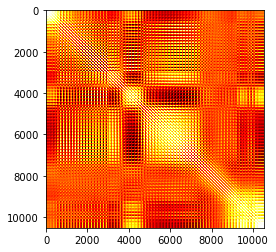

In [63]:
# visualize covariance matrix as heatmap: un-weighted slp (looks almost identical for area-weighted slp, hence not shown here)
plt.imshow(slp_cov, cmap='hot', interpolation='nearest')
plt.show()

# Note: have cov = 1 on diagonal as expected, since we used standardized inputs

In [64]:
# analyse differences of cov-matrices based on un-weighted and area-weighted slp field, respectively
temp_cov = (slp_cov - slp_weighted_cov)

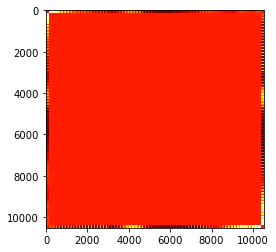

In [65]:
# visualize difference in cov-matrices
plt.imshow(temp_cov, cmap='hot', interpolation='nearest')
plt.show()

In [66]:
# Get eigenvalues and -vectors of covariance matrix.
# Note: We keep both tracks - un-weighted (slp_all) and area-weighted (slp_all_weighted) - for comparision

# CAREFULL: Calculation of Eigenvectors and -values is quite time-consuming!
eval, evec = np.linalg.eig(slp_cov)
#eval_weighted, evec_weighted = np.linalg.eig(slp_weighted_cov)

# Note: resulting eigenvalues come in descending order already.
# And: Since we only have 192 input samples (time dimension!), we can only expect a maximum of 192 non-zero eigenvalues

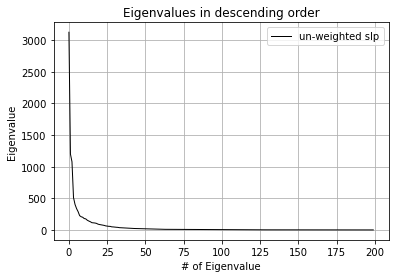

In [67]:
# quick glance at (only the real part of) eigenvalues
plt.plot(np.real(eval[:200]), label='un-weighted slp', color='black', linewidth=1)
#plt.plot(np.real(eval_weighted[:200]), label='area-weighted slp', color='blue', linewidth=1)
plt.ylabel('Eigenvalue')
plt.xlabel('# of Eigenvalue')
plt.title('Eigenvalues in descending order')
plt.legend()
plt.grid()
plt.show()

In [68]:
# Now we want to have look at the cumulative covariance explained by the Eigenvecors (eval_acc).
# Note: We keep both tracks - un-weighted (slp_all) and area-weighted (slp_all_weighted) - for comparision

eval_sum = sum(np.real(eval))
eval_acc = np.zeros(len(eval))

for i in range(len(eval)):
    if i == 0:
        eval_acc[i] = np.real(eval[i]) / eval_sum
    else:
        eval_acc[i] = eval_acc[i-1] + np.real(eval[i]) / eval_sum
        
#eval_weighted_sum = sum(np.real(eval_weighted))
#eval_weighted_acc = np.zeros(len(eval_weighted))

#for i in range(len(eval_weighted)):
#    if i == 0:
#        eval_weighted_acc[i] = np.real(eval_weighted[i]) / eval_weighted_sum
#    else:
#        eval_weighted_acc[i] = eval_weighted_acc[i-1] + np.real(eval_weighted[i]) / eval_weighted_sum
    
    

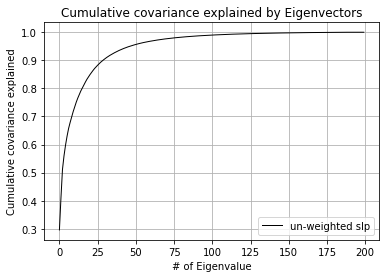

In [69]:
# quick glance accumulated eigenvalues
plt.plot(eval_acc[:200], label='un-weighted slp', color='black', linewidth=1)
#plt.plot(eval_weighted_acc[:200], label='area-weighted slp', color='blue', linewidth=1)
plt.ylabel('Cumulative covariance explained')
plt.xlabel('# of Eigenvalue')
plt.title('Cumulative covariance explained by Eigenvectors')
plt.legend()
plt.grid()
plt.show()

In [70]:
# Now focus on the first eigenvector, EOF_1
# Here: un-weighted slp
print("covariance explained by first Eigenvector: ", np.round(np.real(eval[0]) / eval_sum * 100, 1), "%")

EOF_1_raw = np.real(evec[:,0])
EOF_1_reshape = np.reshape(EOF_1_raw, (slp_all.shape[1], slp_all.shape[2]))

# embedding EOF_1 back into the original lat/lon grid (quick'n'dirty)
EOF_1 = slp_all[0]
EOF_1.values = EOF_1_reshape

covariance explained by first Eigenvector:  29.6 %


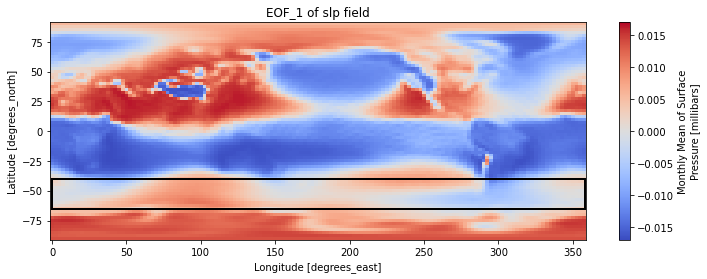

In [71]:
# plot EOF_1, highlighting ACC region
fig, ax = plt.subplots(figsize=(12, 4))
EOF_1.name = 'EOF_1 of slp field'
EOF_1.plot(ax=ax, cmap='coolwarm')#, vmax=295, vmin=280)
plt.title('EOF_1 of slp field')

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((0, -65), 358, 25, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()

In [72]:
# plot un-weighted EOF_1 with view on Antarctis (as done in [Gong & Wang, 1999] figure 1)
proj = cartopy.crs.LambertAzimuthalEqualArea(central_latitude=-90, central_longitude=180)

(
    EOF_1.rename("EOF_1").hvplot(
        geo=True,
        cmap='coolwarm',
        #clim=(260,290),
        title="EOF_1 of slp field",
        projection=proj,
    )
) * gv.feature.coastline(projection=proj)

:Overlay
   .Image.I     :Image   [lon,lat]   (EOF_1)
   .Coastline.I :Feature   [Longitude,Latitude]

In [73]:
# some theoretical aspects on PCA:
# Multiplying standardized inputs (slp_stand) with Eigenvectors gives the "PC-scores".
# Restoring original inputs can be done by multiplying PC-scores with "inverse" Eigenvectors, here: "Transpose",
# since we have ortho-normal Eigenvectors (length normalized to 1).
pc_scores = np.matmul(slp_stand, evec)
evec_T = np.transpose(evec)
restored_input = np.matmul(pc_scores, evec_T)
slp_stand[0,140:160]
np.real(restored_input[0,140:160])

array([-2.13337312, -2.13337284, -2.13335124, -2.13335956, -2.55790339,
       -2.55982237, -2.56031808, -2.5592506 , -2.55899611, -2.55603637,
       -2.55292474, -2.54501199, -2.54144641, -2.53289238, -2.52568114,
       -2.51519989, -2.50550739, -2.49259738, -2.47910826, -2.46187098])

### Discussion on EOF results

Note: Need to be carefull with calculation of Eigenvectors, might crash the remote session due to time-out or dying kernel.

When calculation of Eigenvectors and -values succeeds, we find almost no difference between results for un-weighted and area-weighted slp field.

However, we obtain opposite sign of EOF_1 from un-weighted and area-weighted slp field. This can be solved by simply multiplying EOF with (-1) without destroying the orthonormality of Eigenvector basis.

Our results are comparable to [Gong & Wang (1999)](https://doi.org/10.1029/1999GL900003): Their first EOF accounts for 22.5% of total covariance, while we find 29.6%. The spatial structure of EOF_1 shows Antarctica and its vicinity as one center of same sign (southern boundary of ACC region). Another center of opposite sign covers latitudes adjacent north of ACC region.

In [ ]:
# Now focus on the first eigenvector, EOF_1
# Here: area-weighted slp
print("covariance explained by first Eigenvector: ", np.round(np.real(eval_weighted[0]) / eval_weighted_sum * 100, 1), "%")

EOF_1_raw_weighted = np.real(evec_weighted[:,0])
EOF_1_reshape_weighted = np.reshape(EOF_1_raw_weighted, (slp_all_weighted.shape[1], slp_all_weighted.shape[2]))

# embedding EOF_1 back into the original lat/lon grid (quick'n'dirty)
EOF_1_weighted = slp_all_weighted[0]
EOF_1_weighted.values = EOF_1_reshape_weighted

In [ ]:
# plot EOF_1, highlighting ACC region
# Here: area-weighted slp
fig, ax = plt.subplots(figsize=(12, 4))
EOF_1_weighted.name = 'EOF_1 of area-weighted slp field'
EOF_1_weighted.plot(ax=ax, cmap='coolwarm')#, vmax=295, vmin=280)
plt.title('EOF_1 of area-weighted slp field')

# Create a Rectangle patch and add the patch to the Axes
rect = patches.Rectangle((0, -65), 358, 25, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(rect)

plt.show()